In [1]:
import os
import sys
import time
import pickle
import prince
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import get_cmap
from matplotlib.font_manager import FontProperties

# 獲取當前工作目錄
current_dir = os.getcwd()
version3_path = os.path.join(current_dir, "TrafficTDApython", "Version3", "tdamapper", "core_old.py")

from sklearn.cluster import AgglomerativeClustering
from tdamapper.core_old import MapperAlgorithm
from tdamapper.cover import CubicalCover
from tdamapper.clustering import FailSafeClustering
from tdamapper.plot import MapperLayoutInteractive, MapperPlot

from models import *
from utils_v3 import *
from plots import *

try:
    myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
    sns.set(style="whitegrid", font=myfont.get_name())
except Exception as e:
    print(e)

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
dataA2 = pd.read_csv("../Version3/Data/A2.csv", low_memory=False)
dataA1 = pd.read_csv("../Version3/Data/A1.csv")

In [5]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他',

    # 兩個欄位只有兩個觀察值不同
    '肇因研判大類別名稱-主要',
    # '肇因研判大類別名稱-個別',
]
# select_lst = dataA1.columns
def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)

    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    # 速限範圍
    dist_df = dist_df[(dist_df['速限-第1當事者'] < 200) &
                      (dist_df['當事者事故發生時年齡'] < 100) &
                      (dist_df['當事者事故發生時年齡'] > 0)]

    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

car_A2 = dist_dfA2[dist_dfA2['當事者行動狀態大類別名稱'] == '車的狀態']
car_A1 = dist_dfA1[dist_dfA1['當事者行動狀態大類別名稱'] == '車的狀態']

car_A1.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
car_A2.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)

car_A2 = car_A2[(car_A2['肇因研判大類別名稱-主要'] != '非駕駛者') &
                  (car_A2['肇因研判大類別名稱-主要'] != '無(非車輛駕駛人因素)') &
                  (car_A2['肇因研判大類別名稱-主要'] != '無(車輛駕駛者因素)')]
car_A1 = car_A1[(car_A1['肇因研判大類別名稱-主要'] != '非駕駛者') &
                  (car_A1['肇因研判大類別名稱-主要'] != '無(非車輛駕駛人因素)') &
                  (car_A1['肇因研判大類別名稱-主要'] != '無(車輛駕駛者因素)')] # 刪掉原因為類似於他提供不了更多資訊，但會使Mapper更加分散

car_A2 = car_A2[car_A2['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄']
car_A1 = car_A1[car_A1['行動電話或電腦或其他相類功能裝置名稱'] != '未紀錄']

car_A2 = car_A2[car_A2['車輛撞擊部位大類別名稱-最初'] != '未紀錄']
car_A1 = car_A1[car_A1['車輛撞擊部位大類別名稱-最初'] != '未紀錄']

/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_29969/1818727237.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_A1.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)
/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_29969/1818727237.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_A2.drop(columns=['當事者行動狀態大類別名稱'], inplace=True)


篩選掉未紀錄資料以及分類人的狀態以及車的狀態

In [6]:
# sampling_ratio = 0.33  # 下採樣比例
# 計算 A1 和 A2 原始數據量比例
# A1_total = len(car_A1)
# A2_total = len(car_A2)
# total_ratio = A1_total / A2_total  # 保留 A1/A2 的比例

# 下採樣
# downsampled_A1, downsampled_A2 = downsample_by_month_simple(car_A1, car_A2, sampling_ratio, total_ratio)
# print(downsampled_A1.shape)
# print(downsampled_A2.shape)

# Concat
rbind_data = pd.concat([car_A1, car_A2], axis=0, ignore_index=True)
rbind_data.drop(columns=['發生月份'], inplace=True)

In [7]:
# 處理年齡和速限
rbind_data = process_age_speed(rbind_data)

# assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print('dummy_data:', dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()

dummy_data: (293181, 146)


In [8]:
rbind_data.columns

Index(['天候名稱', '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '路面狀況-路面鋪裝名稱',
       '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
       '號誌-號誌種類名稱', '號誌-號誌動作名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '肇事逃逸類別名稱-是否肇逃', '道路型態大類別名稱',
       '事故位置大類別名稱', '車道劃分設施-分向設施大類別名稱', '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種',
       '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-主要', '死亡', '受傷'],
      dtype='object')

# Kmode

In [58]:
from kmodes.kmodes import KModes

data_for_kmode = rbind_data.drop(['死亡', '受傷', 'color_for_plot'], axis=1)

cost = []
all_results = {}
K = range(1, 5)

for k in K:

    km = KModes(
    n_clusters=k, 
    init='Huang',
    verbose=1,
    random_state=42,
    n_jobs=10
    )

    labels = km.fit_predict(data_for_kmode)
    cost.append(km.cost_)
    all_results[k] = {
        'cost': km.cost_,
        'labels': labels,
        'centroids': km.cluster_centroids_
    }

optimal_k = K[cost.index(min(cost))]
optimal_result = all_results[optimal_k]

Init: initializing centroids
Init: initializing centroids
Init: initializing centroidsInit: initializing centroids
Init: initializing centroids
Init: initializing centroids
Init: initializing centroids

Init: initializing centroidsInit: initializing centroids

Init: initializing centroids
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Init: initializing clusters
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Starting iterations...
Run 8, iteration: 1/100, moves: 0, cost: 774109.0
Run 4, iteration: 1/100, moves: 0, cost: 774109.0
Run 6, iteration: 1/100, moves: 0, cost: 774109.0
Run 3, iteration: 1/100, moves: 0, cost: 774109.0


In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(K, cost, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

In [ ]:
# with open('Version3/Data/CarData/kmode_result.pickle', 'wb') as f:
#     pickle.dump(all_results, f)

In [155]:
print(pd.Series(all_results[2]['labels']).value_counts())
rbind_data['Cluster'] = all_results[2]['labels']

1    48690
0    46813
Name: count, dtype: int64


# MCA

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.122         2.95%                      2.95%
1              0.119         2.87%                      5.82%
2              0.089         2.15%                      7.97%
3              0.076         1.84%                      9.81%
4              0.075         1.81%                     11.62%
5              0.072         1.73%                     13.35%
6              0.067         1.61%                     14.96%


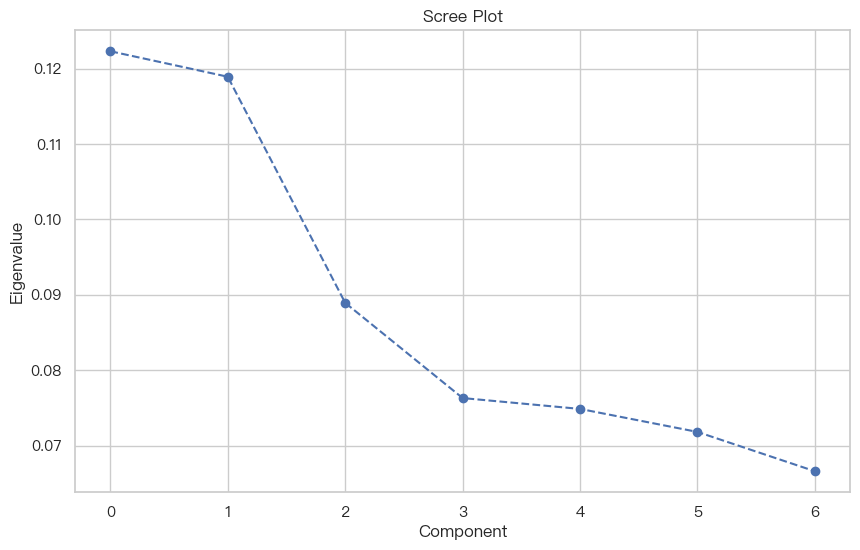

In [11]:
mca = prince.MCA(
    one_hot=False,
    n_components=7,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
    # random_state=43
)

mca.fit(data_to_map)
lens = mca.transform(data_to_map)

print(mca.eigenvalues_summary)

eigenvalues = mca.eigenvalues_

components = range(0, len(eigenvalues))

variance = mca.eigenvalues_summary['% of variance']

plt.figure(figsize=(10, 6))
plt.plot(components, eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.xticks(components)
plt.grid(True)
plt.show()

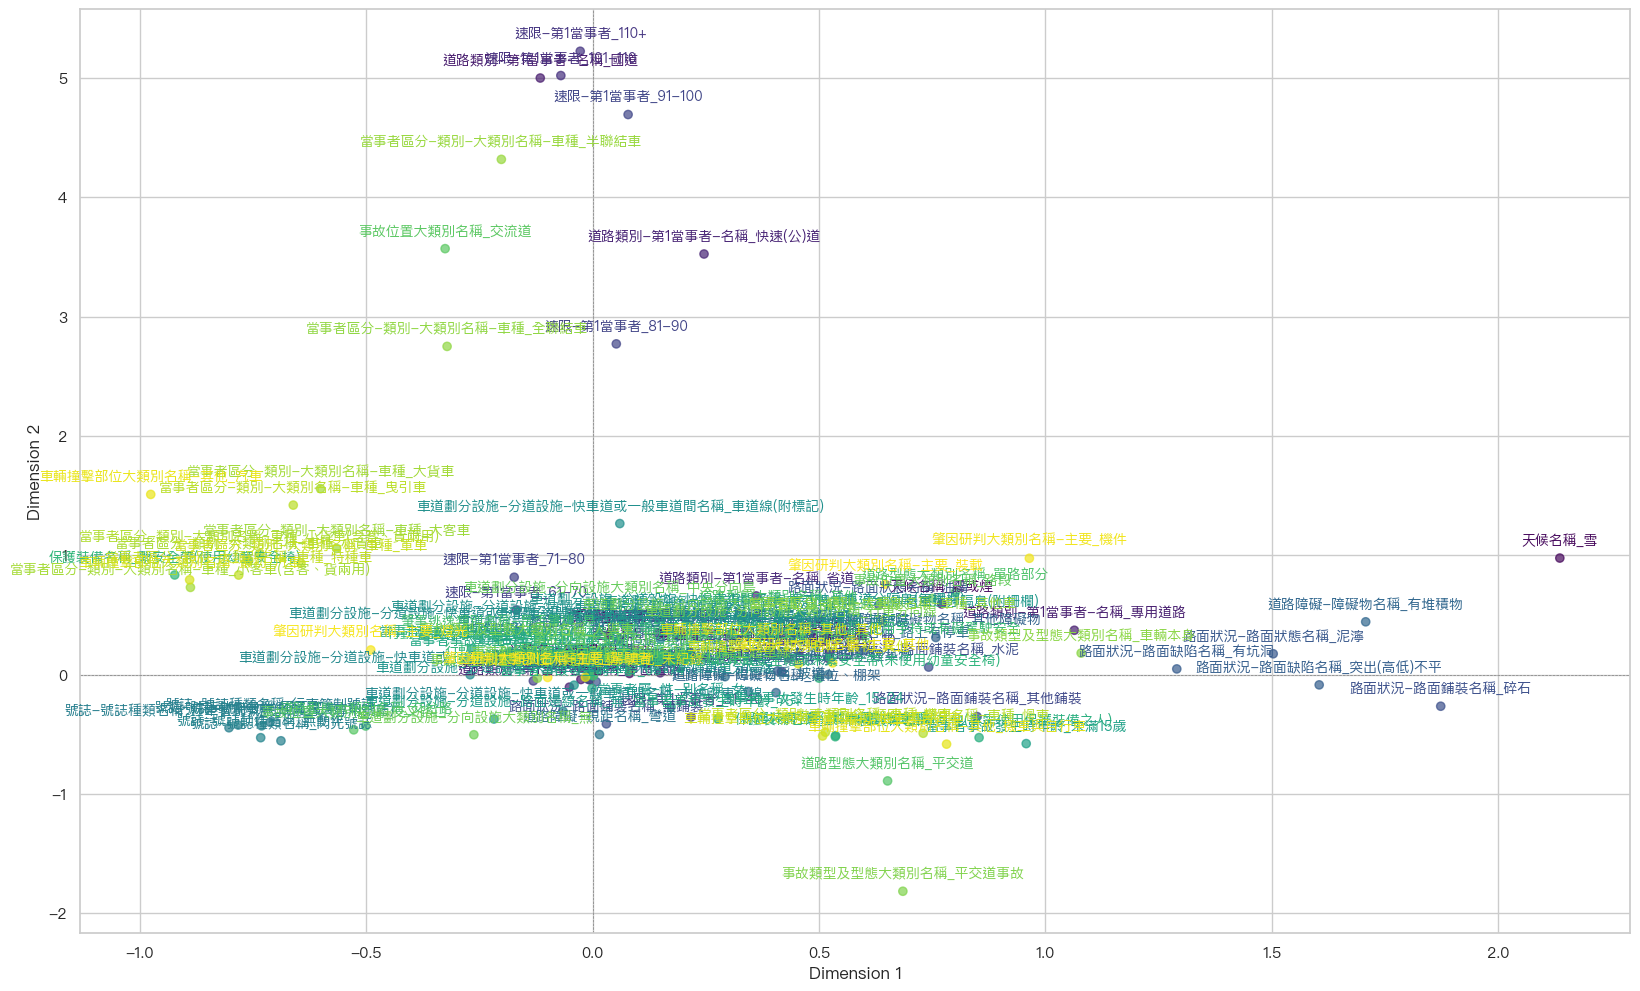

In [12]:
col_coordinate = mca.column_coordinates(data_to_map)

col_coordinate['dummy_index'] = range(len(col_coordinate))  # 為每個欄位分配索引

# Normalize the 'dummy_index' for mapping to colormap
norm = plt.Normalize(vmin=col_coordinate['dummy_index'].min(), vmax=col_coordinate['dummy_index'].max())
cmap = cm.viridis  # 選擇漸層色盤，例如 viridis, plasma, inferno 等

plt.figure(figsize=(20, 12))
plt.gca().set_facecolor('white')

# 繪製散點圖，顏色根據 dummy_index 映射
scatter = plt.scatter(
    col_coordinate[0],  # X coordinate
    col_coordinate[1],  # Y coordinate
    c=col_coordinate['dummy_index'],  # 使用索引作為顏色映射
    cmap=cmap,
    alpha=0.7
)

# Adding labels with colors matching the scatter plot
offset = 0.15
for i, label in enumerate(col_coordinate.index):
    plt.text(
        col_coordinate.iloc[i, 0],  # X coordinate
        col_coordinate.iloc[i, 1] + offset,  # Y coordinate
        str(label),  # 假設 label 包含中文
        fontsize=10,
        ha='center', 
        va='center',
        color=cmap(norm(col_coordinate.iloc[i]['dummy_index'])),  # 文字顏色與點顏色一致
        # rotation=30
    )

# Add colorbar
# cbar = plt.colorbar(scatter)
# cbar.set_label("Field Index (Gradient)", fontsize=12)

# Axes lines and grid
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
# plt.title("MCA", fontsize=16)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.grid(True)

plt.show()

In [13]:
Overlap = [2]
Interval = [11]

detailed_results = []

for overlap in Overlap:
    silhouette_for_intervals = []

    for interval in Interval:
        try:
            print(f'overlap: {overlap}, interval: {interval}')

            mapper_algo = MapperAlgorithm(
                cover=CubicalCover(
                    n_intervals=interval,
                    overlap_frac=overlap / 10
                ),
                clustering=FailSafeClustering(
                    AgglomerativeClustering(
                        n_clusters=2,
                        linkage='ward'
                    )
                ),
                n_jobs=10
            )

            mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
            silhouette_for_intervals.append(mapper_info[1])

            result = {
                "overlap": overlap,
                "interval": interval,
                "silhouette": mapper_info[1],
                "mapper_info": mapper_info
            }

            detailed_results.append(result)

            filename = f"../Version3/Gridsearch/Component7Car/results_o{overlap}i{interval}_new_noresemple.pkl"

            with open(filename, 'wb') as file:
                pickle.dump(result, file)

            print(f"Results saved to {filename}")

        except Exception as e:
            print(f"Error for overlap={overlap}, interval={interval}: {e}")

            continue

overlap: 2, interval: 11


01/02/2025 02:01:18 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 144)) while a minimum of 2 is required by AgglomerativeClustering.
01/02/2025 02:01:45 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 144)) while a minimum of 2 is required by AgglomerativeClustering.
01/02/2025 02:02:04 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 144)) while a minimum of 2 is required by AgglomerativeClustering.
01/02/2025 02:02:04 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 144)) while a minimum of 2 is required by AgglomerativeClustering.
01/02/2025 02:02:10 PM core WARNING: Unable to perform clustering on local chart: Found array with 1 sample(s) (shape=(1, 144)) while a minimum of 2 is required by AgglomerativeClustering.
01/02/2025 02:02:52 PM core WARNING: Unable to perform 

Results saved to ../Version3/Gridsearch/Component7Car/results_o2i11_new_noresemple.pkl


# 國科會模型為O2I11，seed為87，iter=150

In [14]:
detailed_results_df = pd.DataFrame(detailed_results)

# with open('Version3/GridSearch/Component7Car/results_o2i11_new.pkl', 'rb') as f:
#     detailed_results_df = pickle.load(f)

In [156]:
rbind_data['顯著特徵'] = rbind_data['道路型態子類別名稱'] + ',' + rbind_data['號誌-號誌動作名稱'] + ',' + rbind_data['天候名稱']
rbind_data['顯著特徵'].unique()

array(['三岔路,無號誌,陰', '三岔路,正常,晴', '三岔路,正常,陰', '直路,無號誌,晴', '橋樑,無號誌,晴',
       '四岔路,正常,晴', '彎曲路及附近,無號誌,晴', '直路,無號誌,雨', '直路,無號誌,陰', '四岔路,不正常,晴',
       '多岔路,無號誌,雨', '地下道,無號誌,晴', '地下道,無號誌,陰', '涵洞,無號誌,晴', '直路,正常,晴',
       '三岔路,無號誌,晴', '多岔路,正常,陰', '四岔路,無號誌,晴', '坡路,無號誌,晴', '彎曲路及附近,無號誌,陰',
       '彎曲路及附近,正常,晴', '高架道路,無號誌,晴', '多岔路,正常,晴', '彎曲路及附近,無號誌,雨',
       '四岔路,正常,陰', '四岔路,無號誌,雨', '圓環,無號誌,晴', '三岔路,正常,雨', '多岔路,無號誌,晴',
       '四岔路,無號誌,陰', '隧道,無號誌,晴', '直路,正常,陰', '直路,正常,雨', '其他,無號誌,晴',
       '四岔路,正常,雨', '三岔路,無號誌,雨', '橋樑,無號誌,雨', '其他,正常,晴', '三岔路,無動作,陰',
       '高架道路,無號誌,雨', '多岔路,正常,雨', '三岔路,無動作,晴', '橋樑,無號誌,陰', '四岔路,無號誌,霧或煙',
       '三岔路,無號誌,風', '多岔路,無號誌,陰', '坡路,無號誌,陰', '地下道,正常,晴', '其他,無號誌,陰',
       '四岔路,正常,風', '直路,無號誌,霧或煙', '彎曲路及附近,無號誌,霧或煙', '坡路,無號誌,雨',
       '四岔路,無動作,晴', '橋樑,正常,晴', '圓環,正常,晴', '高架道路,正常,晴', '直路,無動作,晴',
       '地下道,無號誌,雨', '其他,正常,陰', '三岔路,正常,霧或煙', '隧道,無號誌,陰', '直路,無號誌,風',
       '隧道,正常,晴', '三岔路,無號誌,霧或煙', '三岔路,不正常,晴', '彎曲路及附近,無號誌,風', '坡路,正常,陰',
       '涵洞,無號誌,陰', '隧道,正常,陰', '高架道路,無

# 目前分析使用的模型

In [22]:
rbind_data.columns

Index(['天候名稱', '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '路面狀況-路面鋪裝名稱',
       '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
       '號誌-號誌種類名稱', '號誌-號誌動作名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '肇事逃逸類別名稱-是否肇逃', '道路型態大類別名稱',
       '事故位置大類別名稱', '車道劃分設施-分向設施大類別名稱', '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種',
       '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-主要', '死亡', '受傷',
       'color_for_plot'],
      dtype='object')

In [ ]:
choose = '車輛撞擊部位大類別名稱-最初'

for i in range(87, 100):
    print(f'Seed: {i}')
    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=i, iterations=100)
    mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    full_info = mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, size=15, threshold=0, range_lst=[-0.05, 0.05, 0.1, -0.05])
    mapper_plotter.plot(choose, avg=False, set_label=True, size=100000)

In [ ]:
lst = ['Cluster', '車輛撞擊部位大類別名稱-最初', '當事者事故發生時年齡', '顯著特徵']
# lst = ['當事者事故發生時年齡']

for choose in lst:
    try:
        mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'], rbind_data, seed=87, iterations=150)
        mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
        full_info = mapper_plotter.extract_data()
        mapper_plotter.map_colors(choose, size=15, threshold=700, range_lst=[-0.2, 0.1, 0.2, -0.2])
        mapper_plotter.plot(choose, avg=False, set_label=True, size=100000,
                save_path=f"/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/MapperColor/Car/o2_i11_{choose}.png")
    except Exception as e:
        print(e)
        continue

In [ ]:
lst = ['發生月份', '天候名稱',
       '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱',
       '事故位置大類別名稱', '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
       '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
       '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
       '事故類型及型態子類別名稱', '肇因研判大類別名稱-主要', '肇因研判子類別名稱-主要', '死亡受傷人數',
       '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種', '當事者屬-性-別名稱', '當事者事故發生時年齡',
       '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態大類別名稱', '當事者行動狀態子類別名稱',
       '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位大類別名稱-其他', '車輛撞擊部位子類別名稱-其他',
       '肇因研判大類別名稱-個別', '肇因研判子類別名稱-個別', '肇事逃逸類別名稱-是否肇逃']
lst = ['肇因研判子類別名稱-個別']

for choose in lst:
    try:
        mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'], rbind_data, seed=44, iterations=100)
        mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
        full_info = mapper_plotter.extract_data()
        mapper_plotter.map_colors(choose, size=10, threshold=700, range_lst=[-0.25, 0.25, 0.2, -0.2])
        mapper_plotter.plot(choose, avg=False, set_label=True, size=100000,
                            save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/MapperColor/Car/o2_i14_{choose}.png")
    except Exception as e:
        print(e)
        continue

In [ ]:
choose = '事故位置大類別名稱'

for index in range(detailed_results_df.shape[0]):

    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'].iloc[index][0], rbind_data, detailed_results_df)
    mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    mapper_plotter.extract_data()
    mapper_plotter.map_colors(choose, size=30, threshold=0)
    mapper_plotter.plot(choose, avg=False, set_label=True, size=100000,
                        save_path=f"C:/Users/USER/Desktop/TrafficTDApython/Version3/GridSearch/Mapper/Car/o{detailed_results_df['overlap'].iloc[index]}_i{detailed_results_df['interval'].iloc[index]}.png")


# Polygon

In [ ]:
from shapely.geometry import Point, Polygon

rectangle1 = Polygon([(-0.1, -0.03), (-0.07, 0.1), (0, 0.06), (0.02, 0.04), (-0.06, 0.01)])
rectangle2 = Polygon([(-0.04, -0.02), (-0.06, 0.01), (0.02, 0.04), (0.02, 0.02)])
rectangle3 = Polygon([(-0.04, -0.03), (-0.04, -0.02),(0.02, 0.02), (0.05, 0.05), (0.15, 0.025), (0.07, -0.02)])
rectangle4 = Polygon([(-0.065, -0.1), (-0.04, -0.03), (0.07, -0.02), (0.1, -0.1)])

# filtered_full_info = full_info[(full_info['y'] > -0.2) &
#                                (full_info['y'] < 0.1) &
#                                (full_info['x'] > -0.1) &
#                                (full_info['x'] < 0.15)]
# filtered_full_info = filtered_full_info[filtered_full_info['size'] > 15]
filtered_full_info = full_info

# 檢查每個點是否在任意一個區塊內
inside_indices_1 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle1), axis=1)
inside_indices_2 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle2), axis=1)
inside_indices_3 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle3), axis=1)
inside_indices_4 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle4), axis=1)

label_0 = filtered_full_info[inside_indices_1]
label_1 = filtered_full_info[inside_indices_2]
label_2 = filtered_full_info[inside_indices_3]
label_3 = filtered_full_info[inside_indices_4]

# 提取區域內和區域外的數據
all_inside_indices = inside_indices_1 | inside_indices_2 | inside_indices_3 | inside_indices_4
outside_indices = ~all_inside_indices

label_out = filtered_full_info[outside_indices]

# assert label_0.shape[0] + label_1.shape[0] + label_out.shape[0] == filtered_full_info.shape[0]

# 繪製數據點和矩形區塊
plt.figure(figsize=(10, 8))
plt.scatter(label_0['x'], label_0['y'], color='green', s=10)
plt.scatter(label_1['x'], label_1['y'], color='blue', s=10)
plt.scatter(label_2['x'], label_2['y'], color='purple', s=10)
plt.scatter(label_3['x'], label_3['y'], color='orange', s=10)
plt.scatter(label_out['x'], label_out['y'], color='red', s=10)

# 繪製矩形區塊
for rect, color, alpha in zip([rectangle1, rectangle2, rectangle3, rectangle4], 
                              ['green', 'blue', 'purple', 'orange'], 
                              [0.2, 0.2, 0.2, 0.2]):
    x, y = rect.exterior.xy
    plt.fill(x, y, color=color, alpha=alpha)

# 圖形調整
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

模型順序
由於1，2群體在拓樸中有過渡的性質，且是從號誌到無號誌，死亡的分布有增加的趨勢，所以使用羅吉斯 <br/>
3，4群體是從這兩個群體的雨天分割出來的，在分布上可看出較類似於不同群體，因為邊的連接較少，所以使用SVM <br/>
5、6群體是離群值以及覆蓋值，分別是群體間的不相似、相似特徵，認為在空間分布上也是類似於分群，所以使用SVM

In [136]:
# 獲取每個label的index
count_0 = get_unique_ids(label_0)
count_1 = get_unique_ids(label_1)
count_2 = get_unique_ids(label_2)
count_3 = get_unique_ids(label_3)
count_out = get_unique_ids(label_out)

index_to_groups = {}

# 將索引與群體的關係記錄下來
for group_name, group_indexes in zip(
    ["full_0", "full_1", "full_2", "full_3", "full_out"],
    [count_0, count_1, count_2, count_3, count_out],
):
    for idx in group_indexes:
        if idx not in index_to_groups:
            index_to_groups[idx] = set()
        index_to_groups[idx].add(group_name)

# 找交集索引
intersection_indexes = {idx for idx, groups in index_to_groups.items() if len(groups) > 1}

# 找出群體2和3的交集
intersection_21 = {idx for idx in count_2 if idx in count_1}

# 從交集中移除屬於群體2和3交集的資料
intersection_indexes -= intersection_21

# 移除交集的index
count_0 = [i for i in count_0 if i not in intersection_indexes and i not in intersection_21]
count_1 = [i for i in count_1 if i not in intersection_indexes and i not in intersection_21]
count_2 = [i for i in count_2 if i not in intersection_indexes and i not in intersection_21]
count_3 = [i for i in count_3 if i not in intersection_indexes and i not in intersection_21]
count_out = [i for i in count_out if i not in intersection_indexes and i not in intersection_21]

# 分群處理
full_0 = dummy_data.loc[count_0]
full_1 = dummy_data.loc[count_1]
full_2 = dummy_data.loc[count_2]
full_3 = dummy_data.loc[count_3]
full_out = dummy_data.loc[count_out]
full_21 = dummy_data.loc[list(intersection_21)]
overlap_data = dummy_data.loc[list(intersection_indexes)]

# 確認所有資料都被獲取
assert len(count_0) == full_0.shape[0]
assert len(count_1) == full_1.shape[0]
assert len(count_2) == full_2.shape[0]
assert len(count_3) == full_3.shape[0]
assert len(count_out) == full_out.shape[0]
assert len(intersection_21) == full_21.shape[0]

print(full_0.shape[0] + full_1.shape[0] + full_2.shape[0] + full_3.shape[0] + full_out.shape[0] + full_21.shape[0] + overlap_data.shape[0])
print(dummy_data.shape[0])


95503
95503


In [154]:
full_info.to_csv('./Version3/Data/CarData/full_info.csv', index=False)
full_0.to_csv('./Version3/Data/CarData/full_0.csv', index=False)
full_1.to_csv('./Version3/Data/CarData/full_1.csv', index=False)
full_2.to_csv('./Version3/Data/CarData/full_2.csv', index=False)
full_3.to_csv('./Version3/Data/CarData/full_3.csv', index=False)
full_out.to_csv('./Version3/Data/CarData/full_out.csv', index=False)
overlap_data.to_csv('./Version3/Data/CarData/overlap_data.csv', index=False)
full_21.to_csv('./Version3/Data/CarData/full_21.csv', index=False)

In [ ]:
print(full_0['死亡'].value_counts())
print(full_1['死亡'].value_counts())
print(full_2['死亡'].value_counts())
print(full_3['死亡'].value_counts())
print(full_out['死亡'].value_counts())
print(full_21['死亡'].value_counts())
print(dummy_data['死亡'].value_counts())
print(overlap_data['死亡'].value_counts())

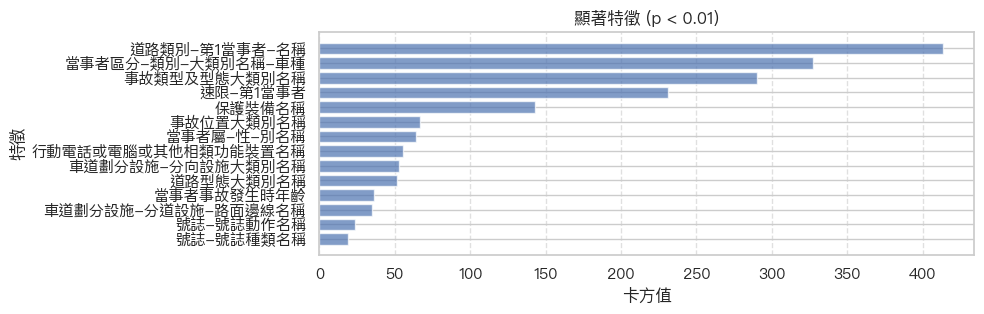

In [17]:
from scipy.stats import chi2_contingency

chi_lst = [
    '天候名稱', '光線名稱', '道路類別-第1當事者-名稱', '速限-第1當事者', '路面狀況-路面鋪裝名稱',
    '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '肇事逃逸類別名稱-是否肇逃', '道路型態大類別名稱',
    '事故位置大類別名稱', '車道劃分設施-分向設施大類別名稱', '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種',
    '車輛撞擊部位大類別名稱-其他']

results = []
rbind_data['death'] = rbind_data['死亡'].apply(lambda x: 1 if x >= 1 else 0)

for chi_value in chi_lst:
    contingency_table = pd.crosstab(rbind_data[chi_value], rbind_data['death'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    if p < 0.01:  # 只篩選顯著結果
        results.append({'變數': chi_value, '卡方值': chi2, '自由度': dof, 'p值': p})

# 將結果轉為資料框
df_results = pd.DataFrame(results).sort_values(by='卡方值', ascending=True)

# 視覺化：條形圖
plt.figure(figsize=(10, 3.3))
plt.barh(df_results['變數'], df_results['卡方值'], alpha=0.7)
plt.xlabel('卡方值')
plt.ylabel('特徵')
plt.title('顯著特徵 (p < 0.01)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [141]:
full_0 = rbind_data.loc[count_0]
full_1 = rbind_data.loc[count_1]
full_2 = rbind_data.loc[count_2]
full_3 = rbind_data.loc[count_3]
full_21 = rbind_data.loc[list(intersection_21)]
full_out = rbind_data.loc[count_out]
overlap_data = rbind_data.loc[list(intersection_indexes)]

# 確認所有資料都被獲取
assert len(count_0) == full_0.shape[0]
assert len(count_1) == full_1.shape[0]
assert len(count_2) == full_2.shape[0]
assert len(count_3) == full_3.shape[0]
assert len(count_out) == full_out.shape[0]

print(full_0.shape[0] + full_1.shape[0] + full_2.shape[0] + full_3.shape[0] + full_out.shape[0] + overlap_data.shape[0] + full_21.shape[0])
print(dummy_data.shape[0])

95503
95503


In [139]:
print(full_0.shape[0])
print(full_1.shape[0])
print(full_2.shape[0])
print(full_3.shape[0])
print(full_out.shape[0])
print(full_21.shape[0])
print(overlap_data.shape[0])

2920
30192
51981
4922
4094
292
1102


In [ ]:
plot_column = '道路類別-第1當事者-名稱'

data_dict = {
    "晴天、機車及自行": full_2[plot_column].value_counts(normalize=True),
    "雨天、機車及自行": full_3[plot_column].value_counts(normalize=True),
    "晴天、汽車": full_1[plot_column].value_counts(normalize=True),
    "雨天、汽車": full_0[plot_column].value_counts(normalize=True),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=True),
    "覆蓋值2": full_21[plot_column].value_counts(normalize=True),
    "離群值": full_out[plot_column].value_counts(normalize=True),
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
comparison_df = comparison_df.sort_values(by='雨天、機車及自行', axis=0, ascending=False)

categories_to_merge = ["縣道", "省道", "鄉道", "國道", "專用道路", "快速(公)道"]
comparison_df.loc["其他"] += comparison_df.loc[categories_to_merge].sum()
comparison_df = comparison_df.drop(index=categories_to_merge)
comparison_df

,晴天、機車及自行,雨天、機車及自行,晴天、汽車,雨天、汽車,覆蓋值,覆蓋值2,離群值
道路類別-第1當事者-名稱,,,,,,,
市區道路,0.812470,0.841325,0.797562,0.813014,0.768603,0.739726,0.485833
村里道路,0.099479,0.079642,0.111354,0.080822,0.090744,0.109589,0.117000
其他,0.088051,0.079033,0.091084,0.106164,0.140653,0.150685,0.397167


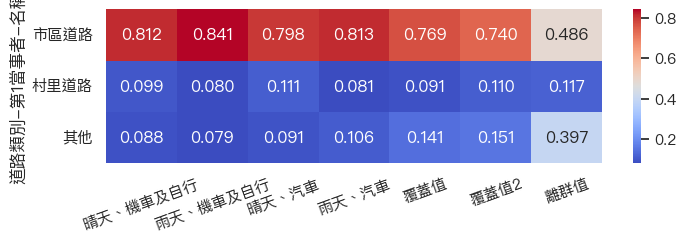

In [143]:
# heatmap
plt.figure(figsize=(8, 2))
sns.heatmap(comparison_df.head(3), annot=True, cmap='coolwarm', fmt=".3f")
# plt.title(f"各群體的道路類別分佈")
plt.xticks(rotation=20)
plt.show()

# 嚴重程度

In [144]:
def get_severity(input_data):
    """
    更新嚴重程度欄位邏輯：
    - 死亡 > 0 時，設定為 2
    - 死亡 = 0 且受傷 = 1 時，設定為 0
    - 死亡 = 0 且受傷 > 1 時，設定為 1
    """
    def severity_logic(row):
        if row['死亡'] > 0:
            return '死亡'
        elif row['死亡'] == 0 and row['受傷'] == 1:
            return '受傷1'
        elif row['死亡'] == 0 and row['受傷'] > 1:
            return '受傷1+'
        else:
            return 0

    input_data['嚴重程度'] = input_data.apply(severity_logic, axis=1)
    return input_data

full_0_s = get_severity(full_0)
full_1_s = get_severity(full_1)
full_2_s = get_severity(full_2)
full_3_s = get_severity(full_3)
full_21_s = get_severity(full_21)
full_out_s = get_severity(full_out)
overlap_data_s = get_severity(overlap_data)

In [145]:
plot_column = '嚴重程度'

data_dict = {
    "晴天、機車及自行": full_2[plot_column].value_counts(normalize=False),
    "雨天、機車及自行": full_3[plot_column].value_counts(normalize=False),
    "晴天、汽車": full_1[plot_column].value_counts(normalize=False),
    "雨天、汽車": full_0[plot_column].value_counts(normalize=False),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=False),
    "覆蓋值2": full_21[plot_column].value_counts(normalize=False),
    "離群值": full_out[plot_column].value_counts(normalize=False),
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
total_row = comparison_df.sum(axis=0)
comparison_df.loc["Total"] = total_row
# comparison_df.loc["Total"] = comparison_df.loc["Total"].astype(int)
comparison_df = comparison_df.sort_values(by='雨天、機車及自行', axis=0, ascending=False)
comparison_df

,晴天、機車及自行,雨天、機車及自行,晴天、汽車,雨天、汽車,覆蓋值,覆蓋值2,離群值
嚴重程度,,,,,,,
Total,51981,4922,30192,2920,1102,292,4094
受傷1,31588,3547,26102,2595,843,231,2913
受傷1+,20177,1358,3970,315,256,57,1135
死亡,216,17,120,10,3,4,46


In [146]:
data_dict = {
    "晴天、機車及自行": full_2[plot_column].value_counts(normalize=True),
    "雨天、機車及自行": full_3[plot_column].value_counts(normalize=True),
    "晴天、汽車": full_1[plot_column].value_counts(normalize=True),
    "雨天、汽車": full_0[plot_column].value_counts(normalize=True),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=True),
    "覆蓋值2": full_21[plot_column].value_counts(normalize=True),
    "離群值": full_out[plot_column].value_counts(normalize=True),
}

# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
# total_row = comparison_df.sum(axis=0)
comparison_df.loc["Total"] = total_row
comparison_df = comparison_df.sort_values(by='雨天、機車及自行', axis=0, ascending=False)
comparison_df

,晴天、機車及自行,雨天、機車及自行,晴天、汽車,雨天、汽車,覆蓋值,覆蓋值2,離群值
嚴重程度,,,,,,,
Total,51981.000000,4922.000000,30192.000000,2920.000000,1102.000000,292.000000,4094.000000
受傷1,0.607684,0.720642,0.864534,0.888699,0.764973,0.791096,0.711529
受傷1+,0.388161,0.275904,0.131492,0.107877,0.232305,0.195205,0.277235
死亡,0.004155,0.003454,0.003975,0.003425,0.002722,0.013699,0.011236


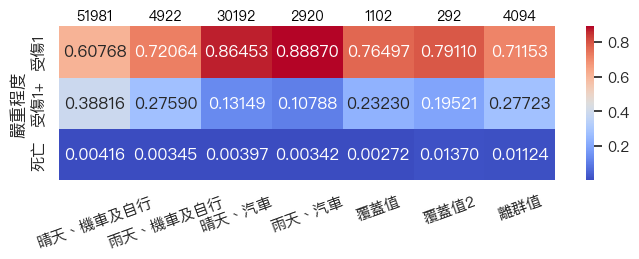

In [147]:
total_row = comparison_df.loc["Total"]

# 提取僅包含數值的列，並移除 Total 行
numeric_df = comparison_df.select_dtypes(include=[float, int]).drop("Total")

# 繪製 heatmap
plt.figure(figsize=(8, 2))
sns.heatmap(numeric_df.tail(3), annot=True, cmap='coolwarm', fmt=".5f")

# 添加總數標註在每個欄位的頂部
for i, total in enumerate(total_row):
    plt.text(i + 0.5, -0.2, f"{int(total)}", ha='center', va='center', fontsize=10, color='black')

# 調整外觀
plt.xticks(rotation=20)
plt.show()


# 雨天影響

In [ ]:
plot_column = '事故類型及型態子類別名稱'

data_dict = {
    "晴天、機車及自行": full_2[plot_column].value_counts(normalize=True),
    "雨天、機車及自行": full_3[plot_column].value_counts(normalize=True),
    "晴天、汽車": full_1[plot_column].value_counts(normalize=True),
    "雨天、汽車": full_0[plot_column].value_counts(normalize=True),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=True),
    "覆蓋值2": full_21[plot_column].value_counts(normalize=True),
    "離群值": full_out[plot_column].value_counts(normalize=True),
}
# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
total_row = comparison_df.sum(axis=0)
# comparison_df.loc["Total"] = total_row
# comparison_df.loc["Total"] = comparison_df.loc["Total"].astype(int)
comparison_df = comparison_df.sort_values(by='晴天、機車及自行', axis=0, ascending=False)

# heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(comparison_df.head(20), annot=True, cmap='coolwarm', fmt=".4f")
# plt.title(f"各群體的道路類別分佈")
plt.xticks(rotation=20)
plt.show()

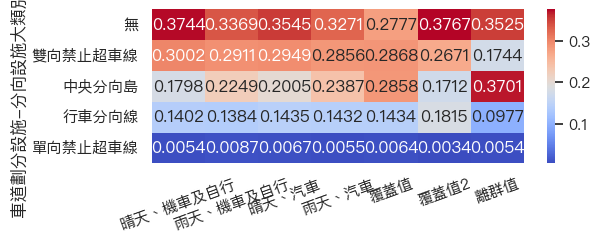

In [152]:
data_dict = {
    "晴天、機車及自行": full_2[plot_column].value_counts(normalize=True),
    "雨天、機車及自行": full_3[plot_column].value_counts(normalize=True),
    "晴天、汽車": full_1[plot_column].value_counts(normalize=True),
    "雨天、汽車": full_0[plot_column].value_counts(normalize=True),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=True),
    "覆蓋值2": full_21[plot_column].value_counts(normalize=True),
    "離群值": full_out[plot_column].value_counts(normalize=True),
}
# 將資料轉為 DataFrame，便於比較
comparison_df = pd.DataFrame(data_dict).fillna(0)
total_row = comparison_df.sum(axis=0)
# comparison_df.loc["Total"] = total_row
# comparison_df.loc["Total"] = comparison_df.loc["Total"].astype(int)
comparison_df = comparison_df.sort_values(by='晴天、機車及自行', axis=0, ascending=False)

# heatmap
plt.figure(figsize=(6, 2))
sns.heatmap(comparison_df.head(10), annot=True, cmap='coolwarm', fmt=".4f")
# plt.title(f"各群體的道路類別分佈")
plt.xticks(rotation=20)
plt.show()

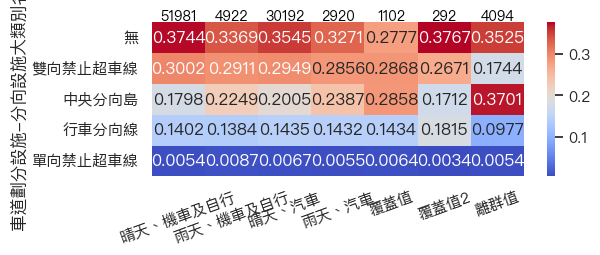

In [153]:

plot_column = '車道劃分設施-分向設施大類別名稱'

data_dict = {
    "晴天、機車及自行": full_2[plot_column].value_counts(normalize=False),
    "雨天、機車及自行": full_3[plot_column].value_counts(normalize=False),
    "晴天、汽車": full_1[plot_column].value_counts(normalize=False),
    "雨天、汽車": full_0[plot_column].value_counts(normalize=False),
    "覆蓋值": overlap_data[plot_column].value_counts(normalize=False),
    "覆蓋值2": full_21[plot_column].value_counts(normalize=False),
    "離群值": full_out[plot_column].value_counts(normalize=False),
}
total_row = pd.DataFrame(data_dict).fillna(0).sum(axis=0)

# heatmap
plt.figure(figsize=(6, 2))
sns.heatmap(comparison_df.head(10), annot=True, cmap='coolwarm', fmt=".4f")
for i, total in enumerate(total_row):
    plt.text(i + 0.5, -0.2, f"{int(total)}", ha='center', va='center', fontsize=10, color='black')

plt.xticks(rotation=20)
plt.show()

# 分類模型

In [ ]:
def get_train_test_data(input_data):
    input_data['y'] = input_data['死亡'].apply(lambda x: 1 if x >= 1 else 0)
    
    new_input_data = input_data.drop(columns=['受傷', '死亡'], inplace=False)
    
    X = new_input_data.drop(columns=['y'])
    y = new_input_data['y']

    return X, y

X0, y0 = get_train_test_data(full_0)
X1, y1 = get_train_test_data(full_1)
X2, y2 = get_train_test_data(full_2)
X3, y3 = get_train_test_data(full_3)
Xout, yout = get_train_test_data(full_out)
Xfull, yfull = get_train_test_data(dummy_data)
Xoverlap, yoverlap = get_train_test_data(overlap_data)

In [ ]:
matrix_0, score_0, cm_0, decision_scores_0 = logistic_cm_gridsearch(X0, y0, threshold=0.5)
matrix_1, score_1, cm_1, decision_scores_1 = logistic_cm_gridsearch(X1, y1, threshold=0.5)
matrix_2, score_2, cm_2, decision_scores_2 = logistic_cm_gridsearch(X2, y2, threshold=0.5)
matrix_3, score_3, cm_3, decision_scores_3 = logistic_cm_gridsearch(X3, y3, threshold=0.5)
matrix_out, score_out, cm_out, decision_scores_out = logistic_cm_gridsearch(Xout, yout, threshold=0.5)
matrix_overlap, score_overlap, cm_overlap, decision_scores_overlap = logistic_cm_gridsearch(Xoverlap, yoverlap, threshold=0.5)

print(matrix_0)
print(matrix_1)
print(matrix_2)
print(matrix_3)
print(matrix_out)
print(matrix_overlap)

In [ ]:
matrix_0, score_0, cm_0, decision_scores_0 = linear_svc_cm_gridsearch(X0, y0, threshold=-1.8)
matrix_1, score_1, cm_1, decision_scores_1 = linear_svc_cm_gridsearch(X1, y1, threshold=-1.8)
matrix_2, score_2, cm_2, decision_scores_2 = linear_svc_cm_gridsearch(X2, y2, threshold=-1.8)
matrix_3, score_3, cm_3, decision_scores_3 = linear_svc_cm_gridsearch(X3, y3, threshold=-1.8)
matrix_out, score_out, cm_out, decision_scores_out = linear_svc_cm_gridsearch(Xout, yout, threshold=-1.8)
matrix_overlap, score_overlap, cm_overlap, decision_scores_overlap = linear_svc_cm_gridsearch(Xoverlap, yoverlap, threshold=-1.8)

print(cm_2)
print(cm_3)
print(cm_out)
print(cm_overlap)

total_cm = cm_2 + cm_3 + cm_out + cm_overlap

total_correct = total_cm[0, 0] + total_cm[1, 1]  # True positives + True negatives
total_samples = total_cm.sum()  # Total samples
accuracy = total_correct / total_samples

print(total_cm, accuracy)

In [ ]:
full_svc_matrix, full_svc_score, full_svc_cm, full_svc_decision_scores = linear_svc_cm_gridsearch(Xfull, yfull, threshold=-1.5)
full_logit_matrix, full_logit_score, full_logit_cm, full_logit_decision_scores = logistic_cm_gridsearch(Xfull, yfull, threshold=0.5)